In [4]:
#Lets have matplotlib "inline"
%matplotlib inline

# Add line profiler
%load_ext line_profiler

#Import packages we need
import numpy as np
from matplotlib import animation, rc
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import gc
import logging

import pycuda.driver as cuda

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#Set large figure sizes
#Note, this prevents nice figures for articles...
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [ ]:
from GPUSimulators.autotuner import Autotuner
from GPUSimulators.model import Force, HLL, HLL2, KP07, LxF, WAF, KP07Dimsplit
from GPUSimulators.common import Timer

In [ ]:
%setup_logging --out autotuning.log --name=autotuning

In [ ]:
autotuner = Autotuner()

In [ ]:
with np.load(autotuner.filename) as data:
    simulators = data['simulators']

    for simulator in simulators:
        megacells = data[simulator + "_megacells"]
        block_widths = data[simulator + '_block_widths']
        block_heights = data[simulator + '_block_heights']
        arguments = data[simulator + '_arguments']

        plt.figure()
        plt.imshow(megacells, origin='lower')  #, vmax=maximum, vmin=minimum)
        plt.xlabel('Block Width')
        plt.xticks(range(len(block_widths)), block_widths)
        plt.ylabel('Block Height')
        plt.yticks(range(len(block_heights)), block_heights)
        plt.colorbar()
        plt.title(simulator)

In [ ]:
simulators = [LxF, Force, HLL, HLL2, KP07, KP07Dimsplit, WAF]
peak_performance = [autotuner.get_peak_performance(simulator) for simulator in simulators]
megacells = [performance['megacells'] for performance in peak_performance]
xlabels = [f"{simulators[i].__name__}\n[{performance['block_width']}x{performance['block_height']}]" for i, performance
           in enumerate(peak_performance)]

plt.figure()
plt.bar(range(len(simulators)), megacells)
plt.xticks(range(len(simulators)), xlabels, rotation=90)
plt.ylabel("Megacells")
plt.title("Simulator performance (megacells)")

In [ ]:
%cuda_context_handler my_context

gen_data: 1647.211552 ms


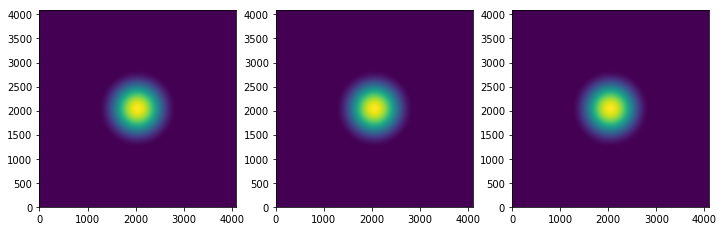

In [ ]:
def gen_test_data(nx, ny, g):
    width = 100.0
    height = 100.0
    dx = width / float(nx)
    dy = height / float(ny)

    x_center = dx * nx / 2.0
    y_center = dy * ny / 2.0

    #Create a gaussian "dam break" that will not form shocks
    size = width / 5.0
    dt = 10 ** 10

    h = np.zeros((ny, nx), dtype=np.float32)
    hu = np.zeros((ny, nx), dtype=np.float32)
    hv = np.zeros((ny, nx), dtype=np.float32)

    extent = 1.0 / np.sqrt(2.0)
    x = (dx * (np.arange(0, nx, dtype=np.float32) + 0.5) - x_center) / size
    y = (dy * (np.arange(0, ny, dtype=np.float32) + 0.5) - y_center) / size
    xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
    r = np.minimum(1.0, np.sqrt(xv ** 2 + yv ** 2))
    xv = None
    yv = None
    gc.collect()

    #Generate highres
    cos = np.cos(np.pi * r)
    h = 0.5 + 0.1 * 0.5 * (1.0 + cos)
    hu = 0.1 * 0.5 * (1.0 + cos)
    hv = hu.copy()

    scale = 0.7
    max_h_estimate = 0.6
    max_u_estimate = 0.1 * np.sqrt(2.0)
    dx = width / nx
    dy = height / ny
    dt = scale * min(dx, dy) / (max_u_estimate + np.sqrt(g * max_h_estimate))

    return h, hu, hv, dx, dy, dt


with Timer("gen_data", log_level=logging.INFO) as t:
    h0, hu0, hv0, dx, dy, dt = gen_test_data(4096, 4096, 9.81)

plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.imshow(h0, origin='lower', interpolation="none")
plt.subplot(1, 3, 2)
plt.imshow(hu0, origin='lower', interpolation="none")
plt.subplot(1, 3, 3)
plt.imshow(hv0, origin='lower', interpolation="none")

In [ ]:
run_simulation = True
sizes = list(range(64, 512, 64)) + list(range(512, 2048, 128)) + list(range(2048, 4096, 256)) + [4096]
simulators = [LxF, Force, HLL, HLL2, KP07, KP07Dimsplit, WAF]
if run_simulation:
    megacells = {}
    for simulator in simulators:
        print(simulator.__name__)
        megacells[simulator.__name__] = np.zeros(len(sizes))
        g = 9.81
        warmup_timesteps = 2
        timesteps = 5
        for k in range(len(sizes)):
            nx = sizes[k] - 1
            ny = sizes[k] - 1

            h0, hu0, hv0, dx, dy, dt = gen_test_data(nx, ny, g)

            arguments = {
                'context': my_context,
                'h0': h0, 'hu0': hu0, 'hv0': hv0,
                'nx': nx, 'ny': ny,
                'dx': dx, 'dy': dy, 'dt': 0.9 * dt,
                'g': g
            }

            sim = simulator(**arguments)

            #Create timer events
            start = cuda.Event()
            end = cuda.Event()

            #Warmup
            for i in range(warmup_timesteps):
                sim.stepEuler(sim.dt)

            #Run simulation with timer        
            start.record(sim.stream)
            for i in range(timesteps):
                sim.stepEuler(sim.dt)
            end.record(sim.stream)

            #Synchronize end event
            end.synchronize()

            sim = None
            gc.collect()

            #Compute megacells
            gpu_elapsed = end.time_since(start) * 1.0e-3
            megacells[simulator.__name__][k] = (nx * ny * timesteps / (1000 * 1000)) / gpu_elapsed
            print("[{:d}x{:d}] => {:.1f} ({:2f})".format(nx, ny, megacells[simulator.__name__][k], gpu_elapsed))

In [ ]:
datafilename = "megacells.npz"
if not os.path.isfile(datafilename) and "megacells" in globals():
    print("Saving data to file")
    np.savez_compressed(datafilename, megacells=megacells)
else:
    print("Loading from file")
    with np.load(datafilename) as file:
        megacells = dict(file["megacells"].tolist())

Text(0.5,0,'nx')

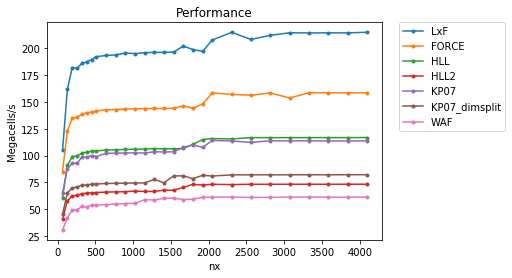

In [ ]:
plt.figure()
for simulator in simulators:
    plt.plot(sizes, megacells[simulator.__name__], '.-', label=simulator.__name__)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Performance")
plt.ylabel("Megacells/s")
plt.xlabel("nx")

Text(0.5,0,'nx')

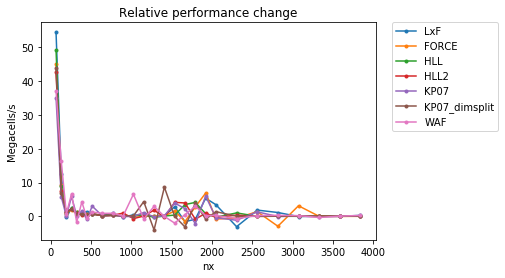

In [ ]:
plt.figure()
for simulator in simulators:
    old = megacells[simulator.__name__][0:-1]
    new = megacells[simulator.__name__][1:]
    change = 100 * (new - old) / old
    plt.plot(sizes[0:-1], change, '.-', label=simulator.__name__)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Relative performance change")
plt.ylabel("Megacells/s")
plt.xlabel("nx")

In [ ]:
print(type(None) is None)

False
